<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [55]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib.ticker import PercentFormatter

In [56]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [57]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    with open(site_freq_path, 'rb') as f:
        countdict = pickle.load(f)
    
    files = glob(os.path.join(path_to_csv_files, 'user????.csv'))
    lOut = []

    for fname in files:
        user_id = int(fname[-8:-4])
        l, t = [], []
        with open(fname) as f:                        
            for line in [line.rstrip() for line in f][1:]:
                atmp = line.split(',')
                l.append(countdict[atmp[1]][0])
                t.append(datetime.strptime(atmp[0], "%Y-%m-%d %H:%M:%S"))
                
        ipos, lenmax = 0, len(l)
        while ipos < lenmax:
            ltmp, ldattmp = np.zeros(session_length), []
            for i_tmp, i_win in enumerate(range(ipos, min(lenmax, ipos+session_length))):
                ltmp[i_tmp] = l[i_win]
                ldattmp.append(t[i_win])
            ipos += window_size 
            dmin = min(ldattmp)
            lOut += [ list(ltmp) +  [ 0, 0, 0, 0, 0, 0, 0, 0, 0] + 
                     [(max(ldattmp) - dmin).total_seconds(), 
                      len(set(ltmp).difference([0])), 
                      dmin.hour, dmin.weekday(), user_id] ]
    
    dfOut = pd.DataFrame( lOut, columns= feature_names, dtype=np.int)
    
    return dfOut

**Проверим функцию на игрушечном примере.**

In [58]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy_0  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [59]:
train_data_toy_0

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,0,0,0,0,0,0,0,0,0,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,0,0,0,0,0,0,0,0,0,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [60]:
%%time
train_data_10users =  prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1.45 s


In [61]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,134,3,134,134,3,134,203,134,0,0,0,0,0,0,0,0,0,33,5,8,4,31
1,425,193,687,254,134,31,394,3841,218,55,0,0,0,0,0,0,0,0,0,284,10,8,4,31
2,55,3,55,55,5,293,425,340,908,55,0,0,0,0,0,0,0,0,0,258,7,8,4,31
3,473,4015,473,55,55,55,55,980,201,123,0,0,0,0,0,0,0,0,0,30,6,8,4,31
4,348,55,5,3837,258,212,3937,2157,676,2157,0,0,0,0,0,0,0,0,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [62]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 12.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [63]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 
                                            'start_hour', 'day_of_week']].values
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 
                                            'start_hour', 'day_of_week']].values

In [64]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [65]:
train_data_10users.session_timespan.median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [66]:
train_data_10users.day_of_week.median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [67]:
train_data_150users.start_hour.median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [68]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [69]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [70]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

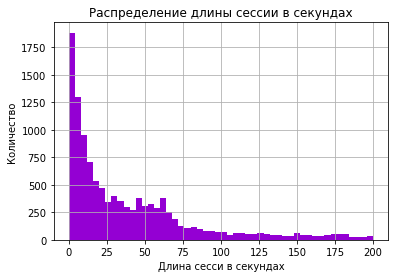

In [100]:
plt.hist(train_data_10users['session_timespan'].values, 50, 
         range=[0, 200],  facecolor='darkviolet')

plt.xlabel('Длина сесси в секундах')
plt.ylabel('Количество')
plt.title('Распределение длины сессии в секундах')
plt.grid(True)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

In [72]:
train_data_10users['#unique_sites'].mean()

5.9513548111798595

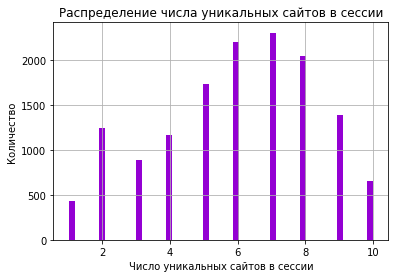

In [73]:
plt.hist(train_data_10users['#unique_sites'].values, 50, 
           facecolor='darkviolet')

plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество')
plt.title('Распределение числа уникальных сайтов в сессии')
plt.grid(True)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

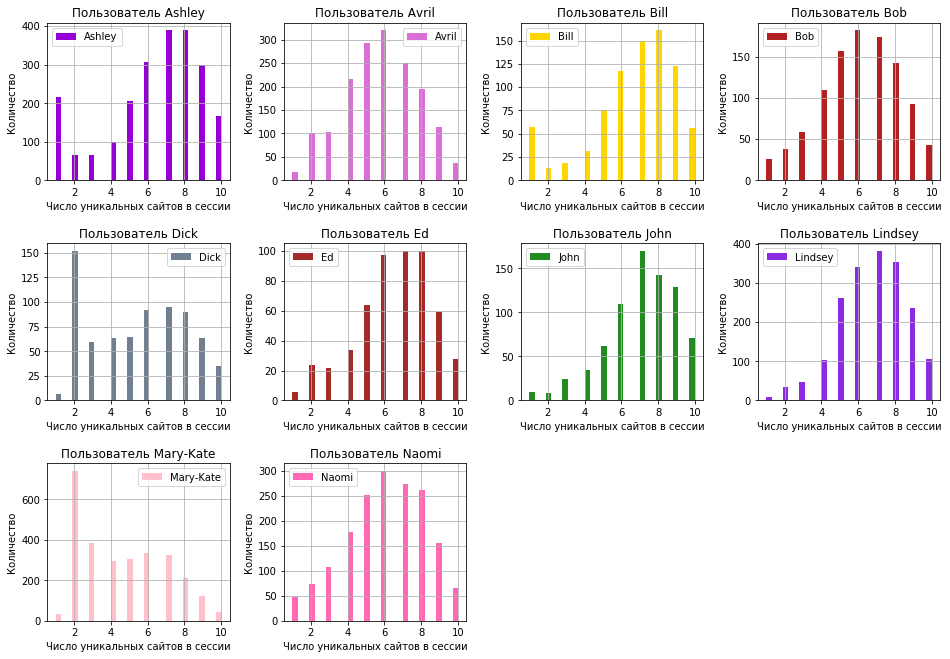

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['#unique_sites']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, 30, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('Число уникальных сайтов в сессии')
    subplot.grid(True)

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.show()

Это не дополнительная характеристика, просто для удобситва анализа на распределения числа уникальных сайтов в сессии для каждого из 10 пользователей по отдельности наложено общее распреление числа уникальных сайтов в сессии. Маркер на диаграмме "Общее"

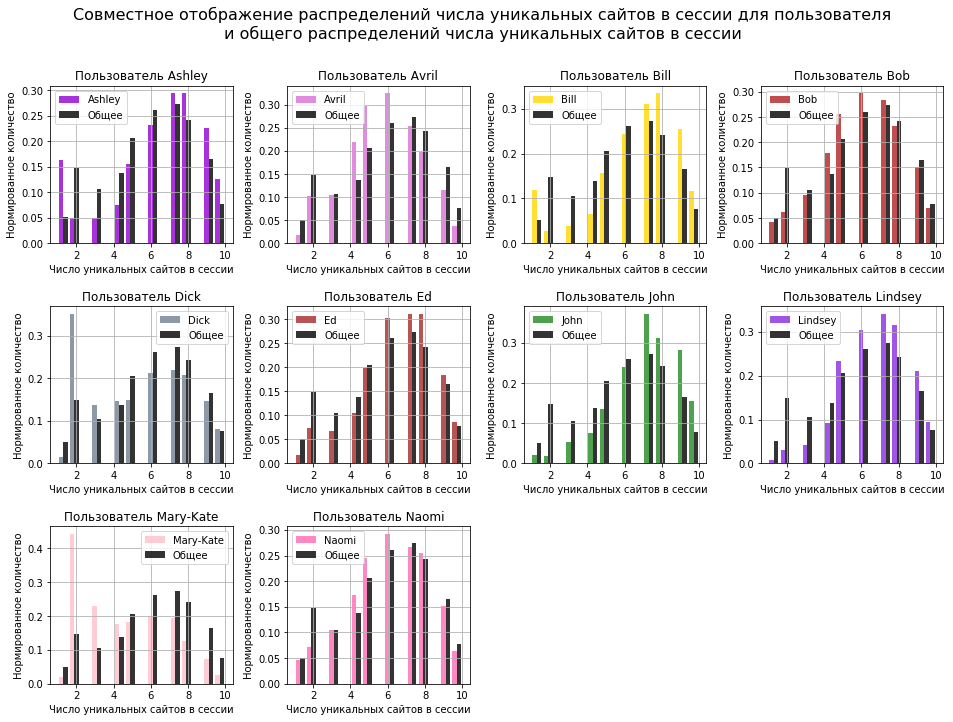

In [75]:
l_common =  train_data_10users['#unique_sites'].values 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['#unique_sites']):
    subplot = axes[idx//4, idx%4]
    subplot.hist([sub_df, l_common], 15, alpha= 0.8, color=[color_dic[user], 'black'], density =True)
    subplot.legend((user, 'Общее', ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Нормированное количество')
    subplot.xaxis.label.set_text('Число уникальных сайтов в сессии')
    subplot.grid(True)

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.suptitle('Совместное отображение распределений числа уникальных сайтов в '
             'сессии для пользователя\nи общего распределений числа уникальных '
             'сайтов в сессии', fontsize=16)
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

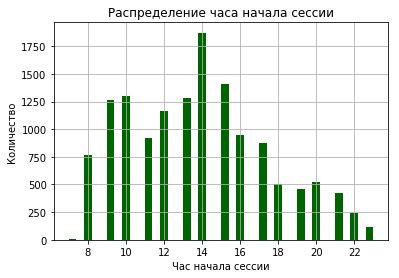

In [76]:
plt.hist(train_data_10users['start_hour'].values, 40,
           facecolor='darkgreen')

plt.xlabel('Час начала сессии')
plt.ylabel('Количество')
plt.title('Распределение часа начала сессии')
plt.grid(True)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

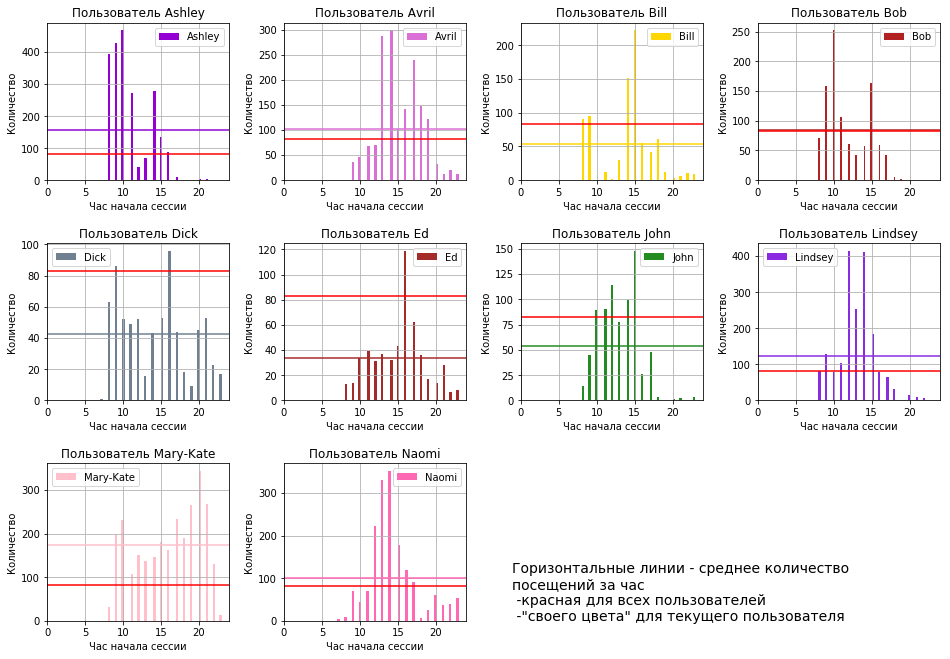

In [77]:
mean_allusers = train_data_10users['start_hour'].count()/(10.* len(train_data_10users['start_hour'].unique()))
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['start_hour']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, 50, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('Час начала сессии')
    subplot.set_xlim([0, 24])
    subplot.grid(True)
    subplot.axhline(y=sub_df.count() / len(sub_df.unique()), color=color_dic[user])
    subplot.axhline(y=mean_allusers, color='r' )

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.text(30, 0, 'Горизонтальные линии - среднее количество\nпосещений за час\n -красная для всех пользователей\n' + 
       ' -"своего цвета" для текущего пользователя', fontsize = 14)


plt.show()

Для удобситва анализа на распределения числа уникальных сайтов в сессии для каждого из 10 пользователей по отдельности наложено общее распреление числа уникальных сайтов в сессии. Маркер на диаграмме "Общее"

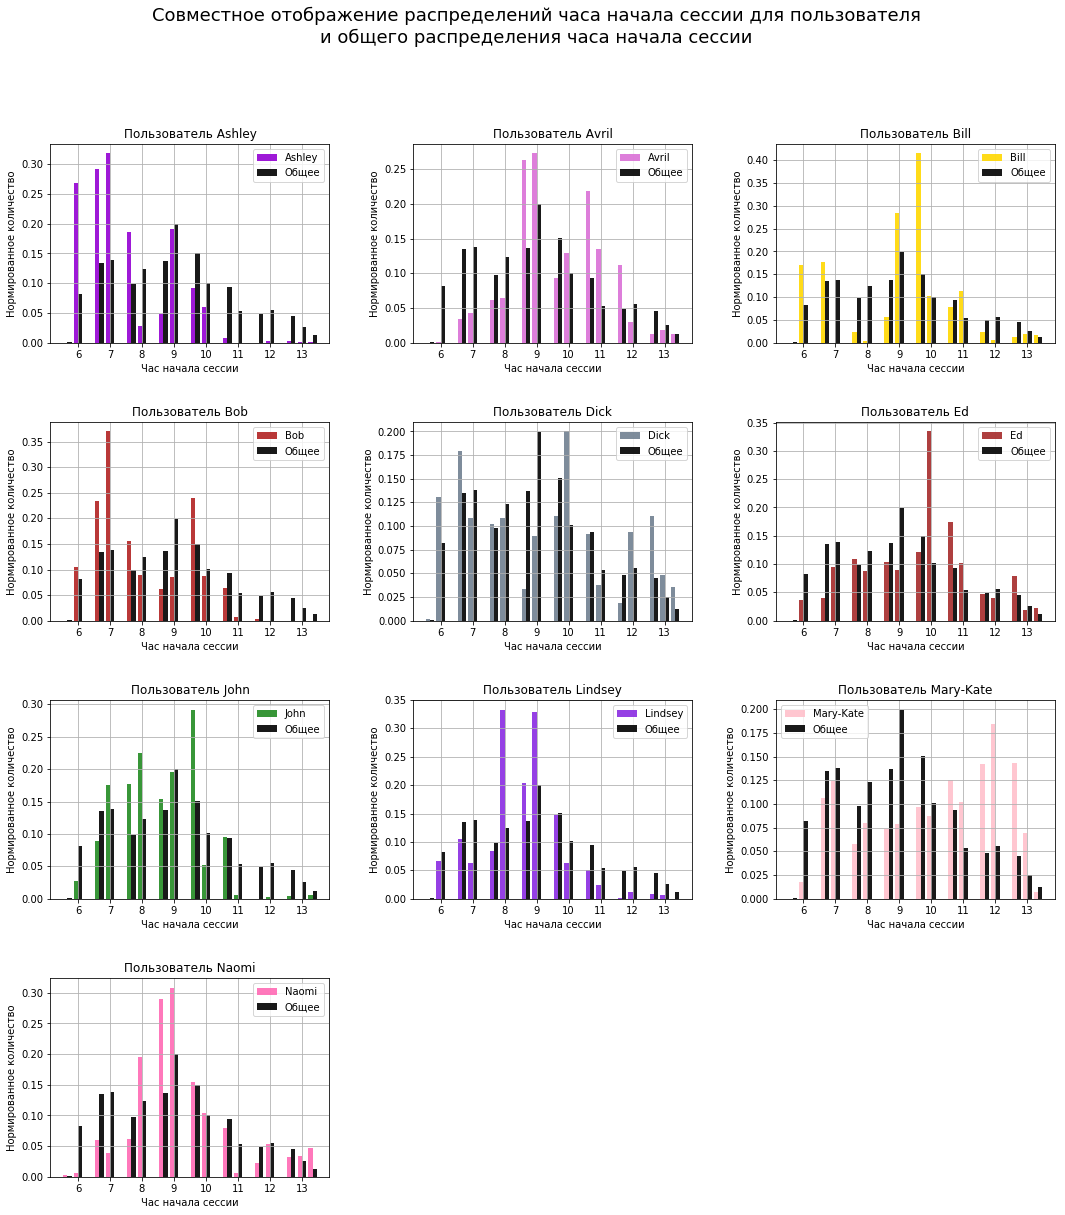

In [78]:
nrows, ncols = 4, 3
l_common = train_data_10users['start_hour'].values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 19),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['start_hour']):
    subplot = axes[idx//ncols, idx%ncols]
    subplot.hist([sub_df, l_common], 24, alpha= 0.9, color=[color_dic[user], 'black'], density =True)
    subplot.legend((user, 'Общее', ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Нормированное количество')
    subplot.xaxis.label.set_text('Час начала сессии')
    subplot.set_xticklabels(range(5, 24))
    subplot.grid(True)

for i in range(idx+1, nrows*ncols):
    fig.delaxes(axes[i//ncols, i%ncols])

plt.suptitle('Совместное отображение распределений часа начала сессии для пользователя\n'
             'и общего распределения часа начала сессии', fontsize=18)
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

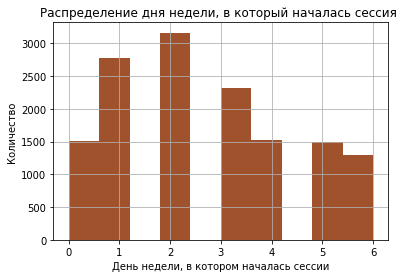

In [79]:
plt.hist(train_data_10users['day_of_week'].values, 
           facecolor='sienna')

plt.xlabel('День недели, в котором началась сессии')
plt.ylabel('Количество')
plt.title('Распределение дня недели, в который началась сессия ')
## plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

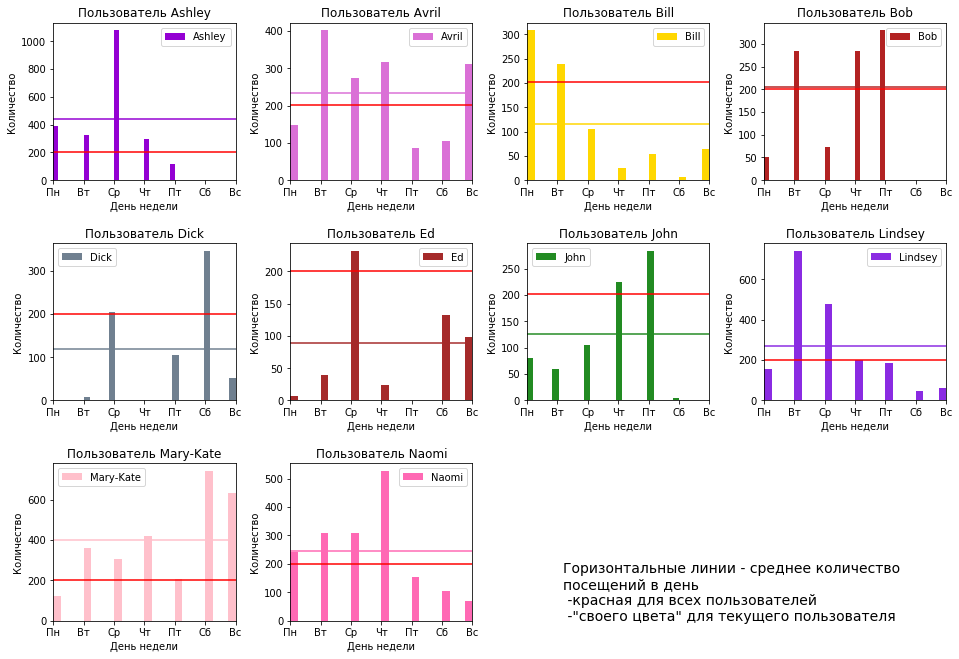

In [80]:
mean_allusers = train_data_10users['day_of_week'].count()/(10.* len(train_data_10users['day_of_week'].unique()))
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 11),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')['day_of_week']):
    subplot = axes[idx//4, idx%4]
    subplot.hist(sub_df, 24, facecolor=color_dic[user])
    subplot.legend((user, ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Количество')
    subplot.xaxis.label.set_text('День недели')
    subplot.set_xlim([0, 6])
    subplot.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    subplot.axhline(y=sub_df.count() / len(sub_df.unique()), color=color_dic[user])
    subplot.axhline(y=mean_allusers, color='r' )

for i in range(idx+1, 3*4):
    fig.delaxes(axes[i//4, i%4])

plt.text(9, 0, 'Горизонтальные линии - среднее количество\nпосещений в день\n -красная для всех пользователей\n' + 
       ' -"своего цвета" для текущего пользователя', fontsize = 14)


plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

**Ashley** - в основном посещает около 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 2, 3, 4 и больше сессий с количеством   уникальных сайтов 1, 9, 10 (здесь и далее указываются различия примерно на 25% и более).
В среднем в течение часа работает почти в два раза больше, чем среднее время работы в течение часа для всех пользователей.
Активно (активным считаем, когда количество больше среднего значения для этого пользователя ) работает с сайтами в периоды 8 - 11, 14 часов. После 17 часов почти не активен.
Не посещает сайты в выходные дни. Активно посещает сайты в среду. В среднем в течениеи дня работает в два раза больше, чем в среднем по всем пользователям.

**Avril** - в основном посещает около 5 - 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 1, 2, 9, 10 и больше сессий с количеством   уникальных сайтов 4, 5.
В среднем в течение часа работает немного больше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период  9 - 23. Активно работает с сайтами в периоды 13, 14 и в 17 часов. После 20 часов активность снижена.
Посещает сайты во все дни недели. Активно посещает сайты во вторник, среду, четверг, воскресенье. В среднем в течение дня работает несколько больше, чем в среднем по всем пользователем.

**Bill** - в основном посещает около 7 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 2, 3, 4, 10 и больше сессий с количеством   уникальных сайтов 1, 9.
В среднем в течение часа работает меньше, чем среднее время работы в течение часа для всех пользователей.
Активно работает с сайтами в период 13 - 19. После 20 часов активность снижена.
Посещает сайты во все дни недели. Активно посещает сайты в понедельник и вторник. В среднем в течение дня работает почти в два раза меньше, чем в среднем по всем пользователем.

**Bob** - в основном посещает около 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 2. Частоты числа уникальных сайтов в сессии у Bob для остальных количеств очень близки к "общей" частоте числа уникальных сайтов в сессии.
В среднем в течение часа работает столько же, как и среднее значение для всех пользователей.
Работает с сайтами в период с 8 до 19. Активно работает с сайтами в периоды 9 - 11, 15 часов. После 17 часов почти не активен.
Не посещает сайты в выходные дни. Активно посещает сайты во вторник, четверг, пятницу. В среднем в течение дня работает столько же, как и в среднем по всем пользователям.

**Dick** - в основном посещает около 5 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов . Частоты числа уникальных сайтов в сессии у Dick для остальных количеств очень близки к "общей" частоте числа уникальных сайтов в сессии.
В среднем в течение часа работает почти в два раза меньше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 8 до 23. Активно работает с сайтами в периоды 8-12, 15- 18, 20, 21 часов.
Не посещает сайты в понедельник и четверг. Активно посещает сайты в среду и субботу. В среднем в течение дня работает почти на треть меньше, чем в среднем по всем пользователем.

**Ed** - в основном посещает около 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 1, 2. Частоты числа уникальных сайтов в сессии у Ed для остальных количеств очень близки к "общей" частоте числа уникальных сайтов в сессии.
В среднем в течение часа работает более чем в два раза меньше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 8 до 23. Активно работает с сайтами в периоды 8-18 часов.
Не посещает сайты в пятницу. Активно посещает сайты в среду, субботу, воскресенье. В среднем в течение дня работает почти в два раза больше, чем в среднем по всем пользователем.

**John** - в основном посещает около 7 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 1, 2, 3, 4 и больше сессий с количеством   уникальных сайтов 7, 9, 10.
В среднем в течение часа работает на четверть меньше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 8 до 17. Активно работает с сайтами в периоды 10-15 часов.
Не посещает сайты в воскресенье.  Активно посещает сайты в четверг и пятницу. В среднем в течение дня работает почти на треть меньше, чем в среднем по всем пользователем.

**Lindsey** - в основном посещает около 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у него значительно меньше сессий с количеством   уникальных сайтов 1, 2, 3, 4.
В среднем в течение часа работает на четверть больше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 8 до 22. Активно работает с сайтами в периоды 9, 12-15 часов.
Посещает сайты во все дни недели. Активно посещает сайты во вторник и среду. В среднем в течение дня работает больше, чем в среднем по всем пользователем.

**Mary-Kate** - в основном посещает около 5 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у нее значительно меньше сессий с количеством   уникальных сайтов 1, 8, 9, 10 и больше сессий с количеством   уникальных сайтов 2, 3.
В среднем в течение часа работает в два раза больше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 8 до 23. Активно работает с сайтами в периоды 9, 10, 15, 17-21 часов.
Посещает сайты во все дни недели. Активно посещает сайты четверг, субботу, воскресенье. В среднем в течение дня работает в два раза больше, чем в среднем по всем пользователем.

**Naomi** - в основном посещает около 6 уникальных сайтов за сессию, при этом по сравнению с картиной "общей" частоты числа уникальных сайтов в сессии у нее значительно меньше сессий с количеством   уникальных сайтов  2. Частоты числа уникальных сайтов в сессии у Naomi  для остальных количеств очень близки к "общей" частоте числа уникальных сайтов в сессии.
В среднем в течение часа работает незначительно больше, чем среднее время работы в течение часа для всех пользователей.
Работает с сайтами в период с 7 до 23. Активно работает с сайтами в периоды  12-16 часов.
Посещает сайты во все дни недели. Активно посещает сайты в понедельник, вторник, среду, четверг. В среднем в течение дня работает больше, чем в среднем по всем пользователем.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [81]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    countdict = pickle.load(f)


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [82]:
top10_sites = list(countdict)[:10]
top10_freqs = [ countdict[k][1] for k in  top10_sites]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

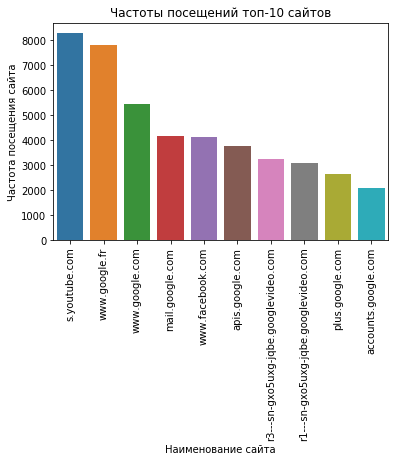

In [83]:
plt.figure()
plt.title('Частоты посещений топ-10 сайтов')
ax = sns.barplot(top10_sites, top10_freqs)
ax.set(xlabel="Наименование сайта", ylabel='Частота посещения сайта')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [84]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    window_size = session_length
    with open(site_freq_path, 'rb') as f:
        countdict = pickle.load(f)
    
    # делим сутки так: ночь с 23 до 7 часов, утро с 7 до 11 часов, 
    # день с 11 до 18 часов, вечер с 18 до 23.
    # данные ориентированы на Википедию.
    lhour = [x for x in range(0, 24)]
    l_day_quarte =[[23] + lhour[0:7], lhour[7:11], lhour[11:18], lhour[18:23]]
    
    #строим список из id сайтов, в которых есть подстрока facebook
    l_facebook_id = [ countdict[s][0] for s in  list(countdict) if 'facebook' in s]
    
    #строим список из id сайтов, из top-30
    l_top30_sites_id = set([ countdict[s][0] for s in  list(countdict)[:30]])
    
    files = glob(os.path.join(path_to_csv_files, 'user????.csv'))
    lOut = []

    for fname in files:
        user_id = int(fname[-8:-4])
        l, t = [], []
        with open(fname) as f:                        
            for line in [line.rstrip() for line in f][1:]:
                atmp = line.split(',')
                l.append(countdict[atmp[1]][0])
                t.append(datetime.strptime(atmp[0], "%Y-%m-%d %H:%M:%S"))
                
        
        
        ipos, lenmax = 0, len(l)
        while ipos < lenmax:
            ltmp, ldattmp = np.zeros(session_length), []
            for i_tmp, i_win in enumerate(range(ipos, min(lenmax, ipos+session_length))):
                ltmp[i_tmp] = l[i_win]
                ldattmp.append(t[i_win])
            ipos += window_size 

            dmin = min(ldattmp)
            ltmp = l[i*window_size: min(i*window_size + session_length, lenmax)]
            countFacebook = sum([1 if i in l_facebook_id else 0 for i in ltmp ])
            # Время сессии принимаем от текущего времени до времени следующего
            # сайта. Если сайт посещали последним в сессии, то данные получить
            # нельзя, и его не считаем.
            timeTop30, isTop30 = 0.0, int(len(l_top30_sites_id & set(ltmp) ) > 0)      
            if isTop30 : 
                timeTop30 = np.mean([x for x in [(ldattmp[i+1] - ldattmp[i]).total_seconds()
                                 for i in np.arange(0, len(ldattmp)-1) 
                                 if ltmp[i] in l_top30_sites_id] if x < 600.])
                
            dayQuarte = [ i for i, r in enumerate(l_day_quarte) if dmin.hour in r][0]  
            lOut += [ ltmp +  [ 0, 0, 0, 0, 0, 0, 0, 0, 0] + 
                     [(max(ldattmp) - dmin).total_seconds(), 
                      len(set(ltmp).difference([0])), 
                      dmin.hour, dmin.weekday(), 
                      dmin.replace(microsecond=0,second=0,minute=0,hour=0),
                      dmin.replace(microsecond=0,second=0,minute=0),
                      dayQuarte, timeTop30, isTop30,
                      countFacebook,  user_id] ]
     
    dfOut = pd.DataFrame( lOut, columns= features) # , dtype=dt)
    return dfOut

In [85]:
%%time

new_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 
                 'YMD',           #год, месяц и день начала сессии
                 'YMDH',          #час начала сессии (с учетом года, месяца и дня)
                 'dayQuarte',     # время суток
                 'timeTop30',     #среднее время пребывания на сайте, для топ-30 популярных сайтов
                 'isTop30',       #индикатор посещения топ-30 популярных сайтов)
                 'countFacebook', #частота посещения Facebook
                 'target']

new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  features=new_feature_names, session_length=10)
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

Wall time: 1.89 s


In [86]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  features=new_feature_names, session_length=10)

Wall time: 21.1 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

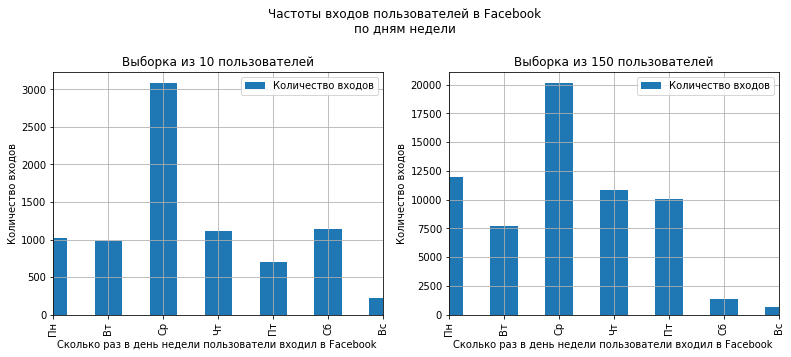

In [87]:
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 5),)

for idx, dfplot in enumerate( [new_features_10users, new_features_150users] ):
    subplot = axes[ idx%ncols]
    df = dfplot[['countFacebook', 'day_of_week']]
    df.groupby('day_of_week').sum().plot(ax=subplot, kind='bar')
    subplot.xaxis.label.set_text('Сколько раз в день недели пользователи входил в Facebook ')
    subplot.yaxis.label.set_text('Количество входов')
    subplot.title.set_text('Выборка из {} пользователей'.format(len(dfplot['target'].unique())))
    subplot.set_xlim([0, 6])
    subplot.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    subplot.legend(('Количество входов', ))
    subplot.grid(True)

    
plt.suptitle('Частоты входов пользователей в Facebook\nпо дням недели')
plt.subplots_adjust(top=0.8)

plt.show()

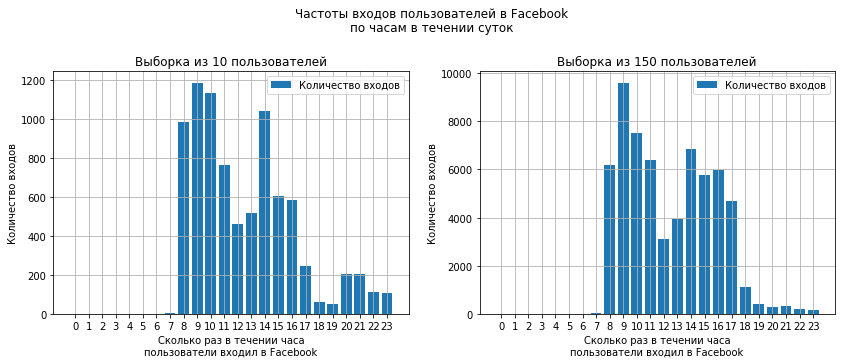

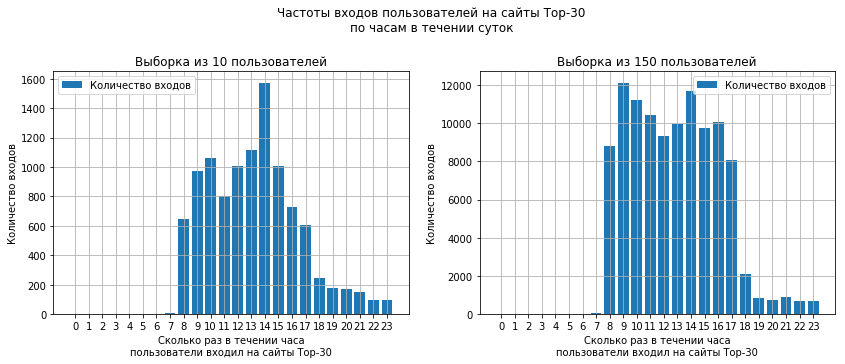

In [88]:
# Не получилось средствами plot() DateFrame отобразить "пустые" ночные часы на диаграмме

def plot_hour_info(field, msg, ldata):
    nrows, ncols = 1, 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 5),)

    for idx, dfplot in enumerate( ldata ):
        subplot = axes[ idx%ncols]
        df = dfplot[[field, 'start_hour']].groupby('start_hour').sum()
        lh = np.zeros(24, dtype=np.int)
        for i, row in df.iterrows():
            lh[i] = row[field]
        subplot.bar(range(24), lh, align='center', alpha=1.)
        subplot.xaxis.label.set_text('Сколько раз в течении часа\nпользователи входил {}'.format(msg))
        subplot.yaxis.label.set_text('Количество входов')
        subplot.title.set_text('Выборка из {} пользователей'.format(len(dfplot['target'].unique())))
        #subplot.set_xticklabels([str(x) for x in range(24)])
        subplot.set_xticks(range(24))
        subplot.legend(('Количество входов', ))
        subplot.grid(True)


    plt.suptitle('Частоты входов пользователей {}\nпо часам в течении суток'.format(msg))
    plt.subplots_adjust(top=0.8)
    plt.show()

plot_hour_info('countFacebook', 'в Facebook', [new_features_10users, new_features_150users])
plot_hour_info('isTop30', 'на сайты Top-30', [new_features_10users, new_features_150users])

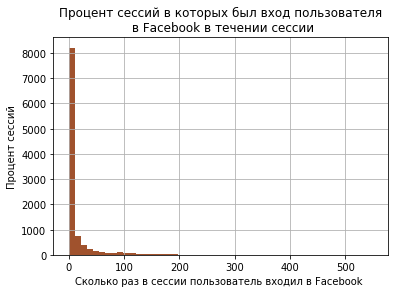

In [89]:
df = new_features_10users[new_features_10users.isTop30 != 0].timeTop30
plt.hist(df, 50, facecolor='sienna')

plt.xlabel('Сколько раз в сессии пользователь входил в Facebook ')
plt.ylabel('Процент сессий')
plt.title('Процент сессий в которых был вход пользователя\n в Facebook в течении сессии')
plt.grid(True)
plt.show()

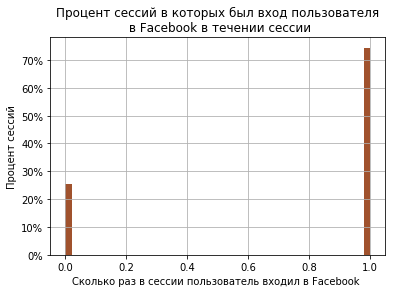

In [90]:
df = new_features_10users['isTop30']
plt.hist(df, 50, weights=np.ones(df.shape[0]) / new_features_10users.shape[0] ,
           facecolor='sienna')

plt.xlabel('Сколько раз в сессии пользователь входил в Facebook ')
plt.ylabel('Процент сессий')
plt.title('Процент сессий в которых был вход пользователя\n в Facebook в течении сессии')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

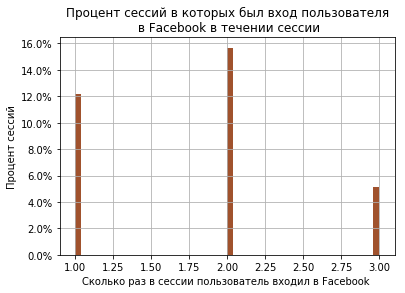

In [91]:
df = new_features_10users[new_features_10users['countFacebook']> 0].countFacebook
plt.hist(df, 50, weights=np.ones(df.shape[0]) / new_features_10users.shape[0] ,
           facecolor='sienna')

plt.xlabel('Сколько раз в сессии пользователь входил в Facebook ')
plt.ylabel('Процент сессий')
plt.title('Процент сессий в которых был вход пользователя\n в Facebook в течении сессии')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

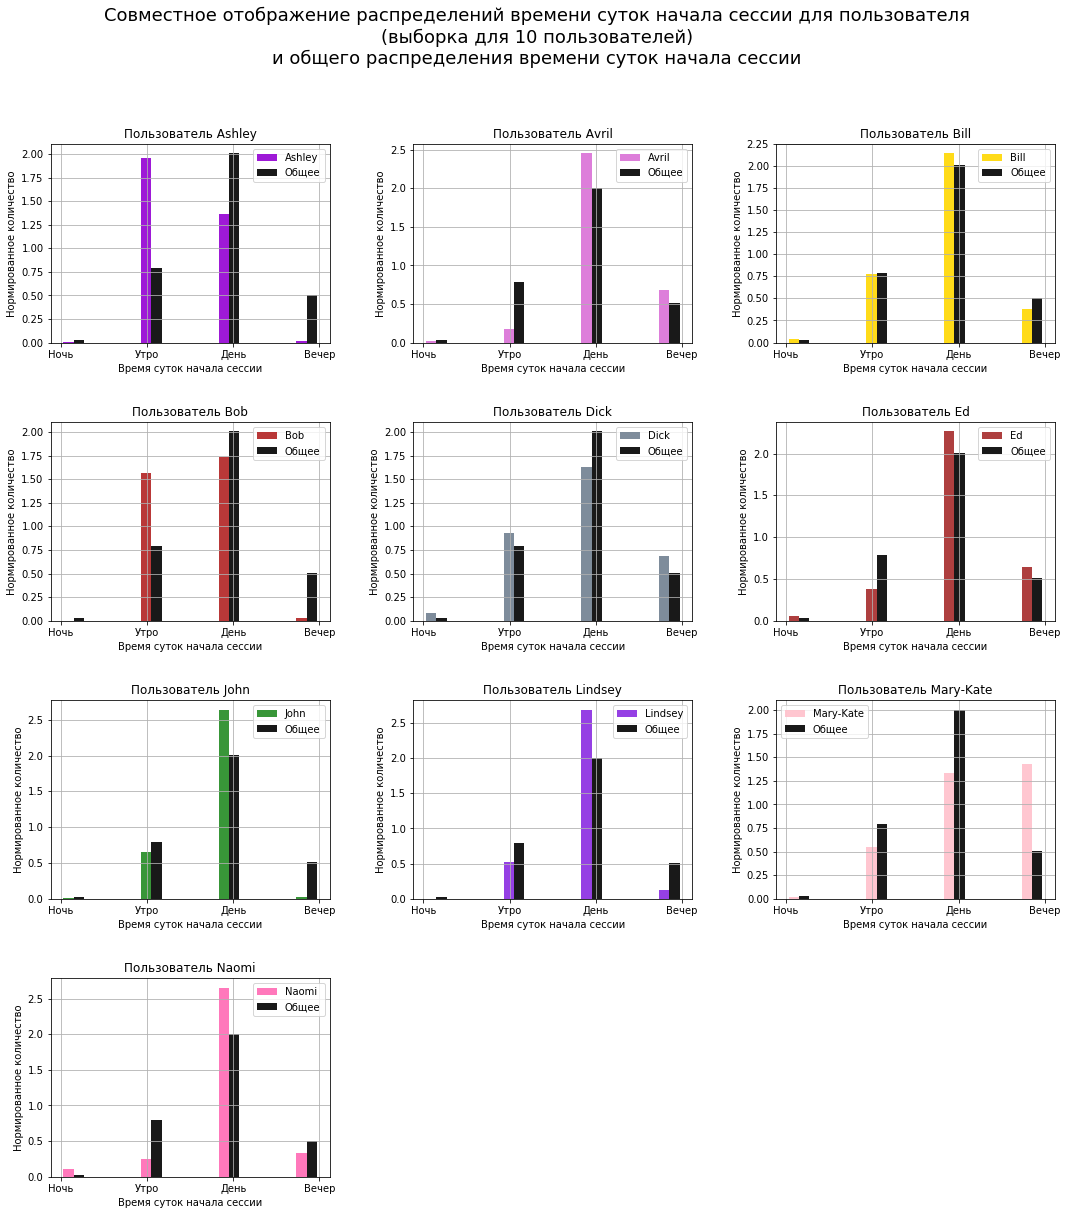

In [92]:
nrows, ncols = 4, 3
l_common = new_features_10users['dayQuarte'].values
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 19),)
plt.subplots_adjust( wspace=.3, hspace=.4)
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby('target')['dayQuarte']):
    subplot = axes[idx//ncols, idx%ncols]
    subplot.hist([sub_df, l_common],  alpha= 0.9, color=[color_dic[user], 'black'], density =True)
    subplot.legend((user, 'Общее', ))
    subplot.title.set_text('Пользователь {}'.format(user))
    subplot.yaxis.label.set_text('Нормированное количество')
    subplot.xaxis.label.set_text('Время суток начала сессии')
    subplot.set_xticks( range(0, 4) )
    subplot.set_xticklabels(['Ночь','Утро','День','Вечер']) #range(0, 4))
    subplot.grid(True)


for i in range(idx+1, nrows*ncols):
    fig.delaxes(axes[i//ncols, i%ncols])

plt.suptitle('Совместное отображение распределений времени суток начала сессии для пользователя\n'
             '(выборка для 10 пользователей)\nи общего распределения времени суток начала сессии', fontsize=18)
plt.show()

На диаграммах ниже отображены влиягтн размера сессиии и окна на гистограмму распределения длины сессии в секундах. 

Как видно из диаграмм существенные изменения не наблюдаются.

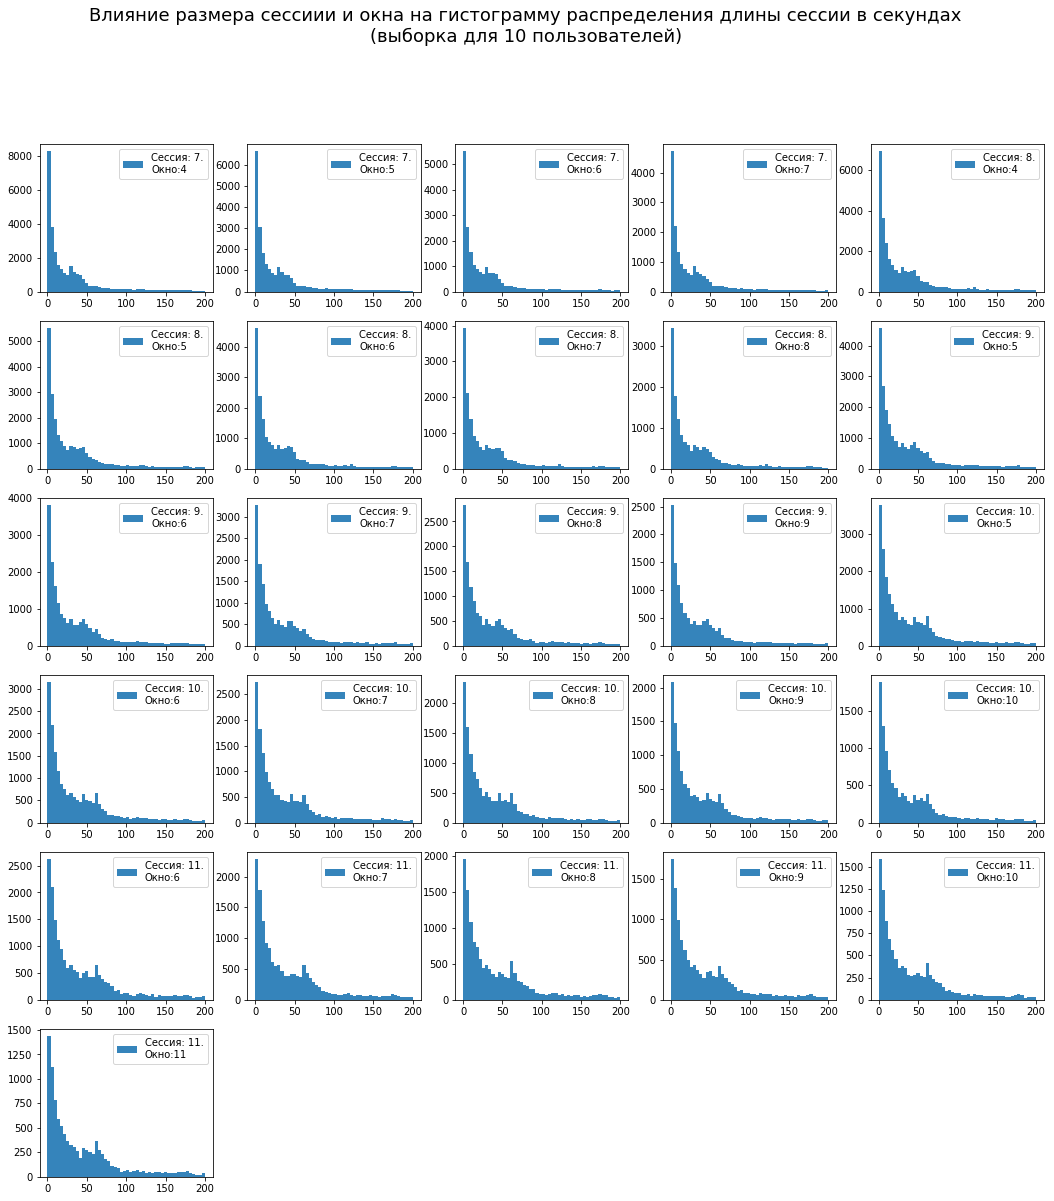

Wall time: 1min 22s


In [93]:
%%time
nrows, ncols, idx = 6, 5, 0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 19),)
for ses_len in range(7, 12):
    for win_size in range(4, 12):
        if win_size <= ses_len and win_size >= ses_len/2:
            feature_names = ['site' + str(i) for i in range(1,ses_len+1)] + \
                            ['time_diff' + str(j) for j in range(1,10)] + \
                            ['session_timespan', '#unique_sites', 'start_hour', 
                             'day_of_week', 'target']
   
            df = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=ses_len, window_size=win_size)
            
            #print(ses_len, win_size, df[df.session_timespan > 300].shape[0])
            subplot = axes[idx//ncols, idx%ncols]
            subplot.hist(df['session_timespan'], 50, alpha= 0.9, range=[0, 200])
            subplot.legend(('Сессия: {}.\nОкно:{}'.format(ses_len, win_size),  ))
            
            idx+=1
            
for i in range(idx, nrows*ncols):
    fig.delaxes(axes[i//ncols, i%ncols])

plt.suptitle('Влияние размера сессиии и окна на гистограмму распределения длины сессии в секундах\n'
             '(выборка для 10 пользователей)', fontsize=18)
plt.show()

In [94]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [95]:
df = new_features_150users.groupby('YMDH', 
    as_index = False)[['session_timespan', 'timeTop30']].mean().copy()
#Не отображаем сессии, длина которых больше нескольких минут
max_ses_len = 4.*60.
df = df[df['session_timespan'] <  max_ses_len]
trace_session_timespan = go.Scatter(
    x = df.YMDH,
    y = df.session_timespan,
    mode = 'lines',
    name = u'Длительность сессии'
)
trace_timeTop30 = go.Scatter(
    x = df.YMDH,
    y = df.timeTop30,
    mode = 'lines',
    name = 'Длительность посещения Top-30 '
)

layout = go.Layout(
    title='График длительности сессий и посещения Top-30 сайтов',
    legend=dict(orientation="h")
)   

fig = go.Figure(data = [trace_session_timespan, trace_timeTop30], layout = layout)
iplot(fig)

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [96]:
saved_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 
                 'YMD',           #год, месяц и день начала сессии
                 'YMDH',          #час начала сессии (с учетом года, месяца и дня)
                 'dayQuarte',     # время суток
                 'timeTop30',     #среднее время пребывания на сайте, для топ-30 популярных сайтов
                 'isTop30',       #индикатор посещения топ-30 популярных сайтов)
                 'countFacebook', #частота посещения Facebook
                 'target']

selected_features_10users = new_features_10users[saved_feature_names]
selected_features_150users = new_features_150users[saved_feature_names]

In [97]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 